# ***Tarea 10. PCA***
### Luis Eduardo Jiménez del Muro - 03/05/2025
---

# *Paqueterías*

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# *Funciones*

In [49]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    plt.figure(figsize=(12,6))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


# *Preparar los datos*

In [2]:
data = pd.read_csv('data/Hitters.csv')
data = pd.get_dummies(data, columns=['League', 'Division', 'NewLeague'])
data = data.fillna(data.mean())

target = 'Salary'
X = data.copy()
X = X.drop(target, axis=1)
y = data[target]

In [3]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [4]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)

X_componentes = pd.DataFrame(X_pca, columns=[f'PCA {i+1}' for i in range(X.shape[1])])
X_componentes.head()

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,...,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,PCA 19,PCA 20,PCA 21,PCA 22
0,-2.961777,-1.149627,-1.682556,1.423163,1.057616,1.444324,0.610788,0.030300,-1.341639,0.637484,...,0.309349,0.229468,-0.047262,-0.176825,0.041682,0.019445,-0.003991,2.726270e-16,-1.007965e-16,9.383920e-17
1,-0.079952,2.170134,1.567645,-1.346423,-0.264996,1.393265,-0.111384,0.067685,-0.271265,0.146457,...,-0.454450,0.413989,0.108644,0.146214,0.088926,0.038865,-0.023782,8.914338e-17,-1.850502e-16,7.164198e-17
2,0.837317,-2.933228,-0.634578,-1.590575,-0.628527,1.768560,-0.423142,1.112942,-0.399268,0.271515,...,0.391727,-0.022519,0.097119,0.141977,0.040376,0.014491,-0.007014,1.199713e-16,1.022579e-17,-1.282054e-16
3,3.301292,1.354905,2.079089,1.441658,-1.254875,-0.859494,0.962639,-0.823411,0.148011,-0.109211,...,0.149257,-0.375405,0.115440,0.010901,-0.207874,0.046478,-0.057237,3.363223e-17,-2.960725e-16,2.659310e-16
4,-2.501280,-0.089023,2.013757,1.379506,-1.541979,1.582789,-0.086527,-0.216498,0.410066,-0.158371,...,0.131861,0.052805,0.048169,0.028817,-0.038557,0.013062,-0.015288,2.556768e-16,-1.850502e-16,2.659310e-16


# *Varianza explicada de los primeros 3 componentes*

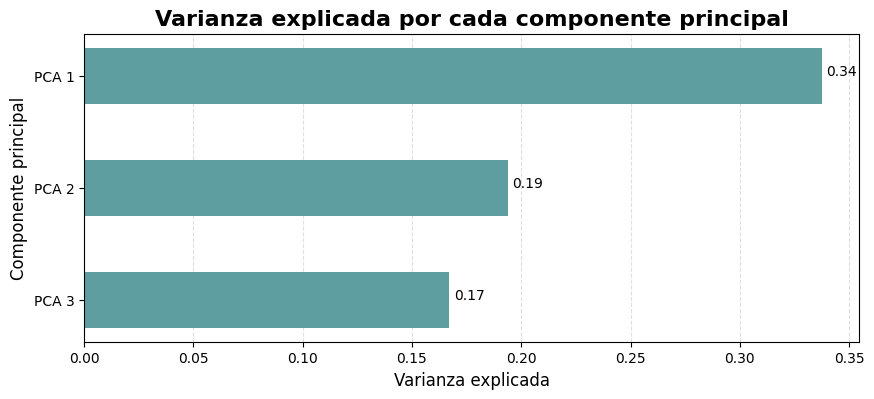

In [5]:
varianza_explicada = pd.DataFrame([explicacion for explicacion in objeto_pca.explained_variance_ratio_]).T
varianza_explicada.columns = [f'PCA {i+1}' for i in range(X.shape[1])]
varianza_explicada = varianza_explicada.T.head(3).sort_index(ascending=False)

plt.figure(figsize=(10, 4))
plt.barh(varianza_explicada.index, varianza_explicada[0], color='cadetblue', zorder=2, height=0.5)

for i, v in enumerate(varianza_explicada[0]):
    plt.text(v + 0.002, i, f'{v:.2f}')

plt.title('Varianza explicada por cada componente principal', fontsize=16, fontweight='bold')
plt.xlabel('Varianza explicada', fontsize=12)
plt.ylabel('Componente principal', fontsize=12)
plt.grid(alpha=0.4, linestyle='--', axis='x', zorder=0)
plt.show()

# *Gráfica de las primeras dos componentes y aplica un KMeans*

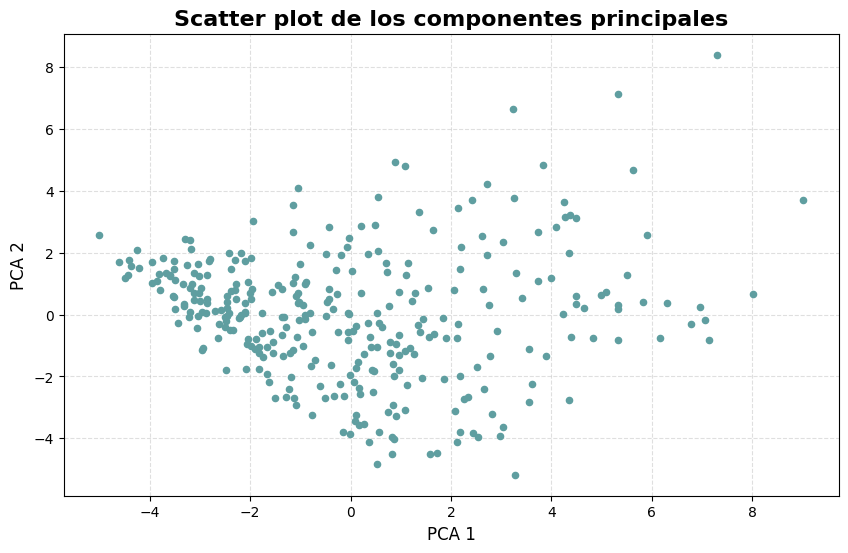

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X_componentes['PCA 1'], X_componentes['PCA 2'], s=20, c='cadetblue', zorder=2)
plt.title('Scatter plot de los componentes principales', fontsize=16, fontweight='bold')
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.grid(alpha=0.4, linestyle='--', zorder=0)

c:\Users\epile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


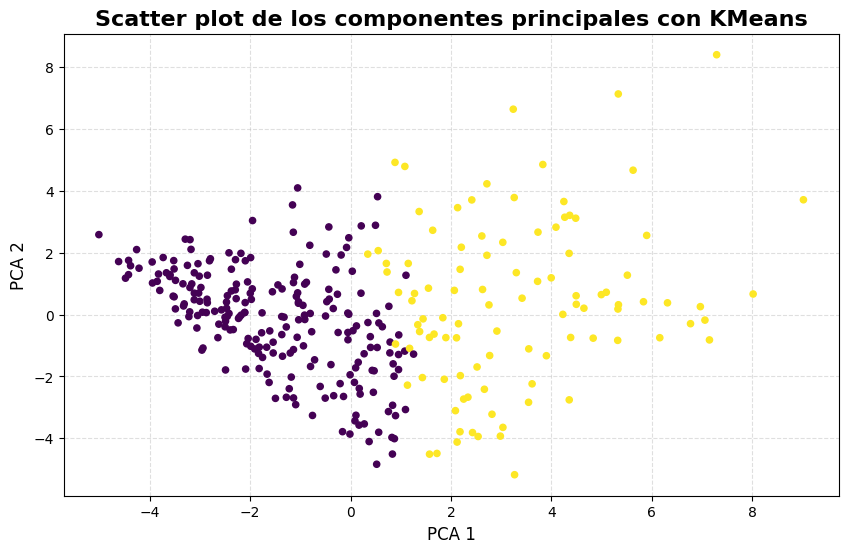

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])
pipeline.fit(X)

X_componentes['cluster'] = pipeline.predict(X) + 1
plt.figure(figsize=(10, 6))
plt.scatter(X_componentes['PCA 1'], X_componentes['PCA 2'], s=20, c=X_componentes['cluster'], cmap='viridis', zorder=2)
plt.title('Scatter plot de los componentes principales con KMeans', fontsize=16, fontweight='bold')
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.grid(alpha=0.4, linestyle='--', zorder=0)
plt.show()

# *Crea un modelo boosting (Catboost, xgboost o lightgbm, el que quieras) y predice con:*

## A) todas las variables 

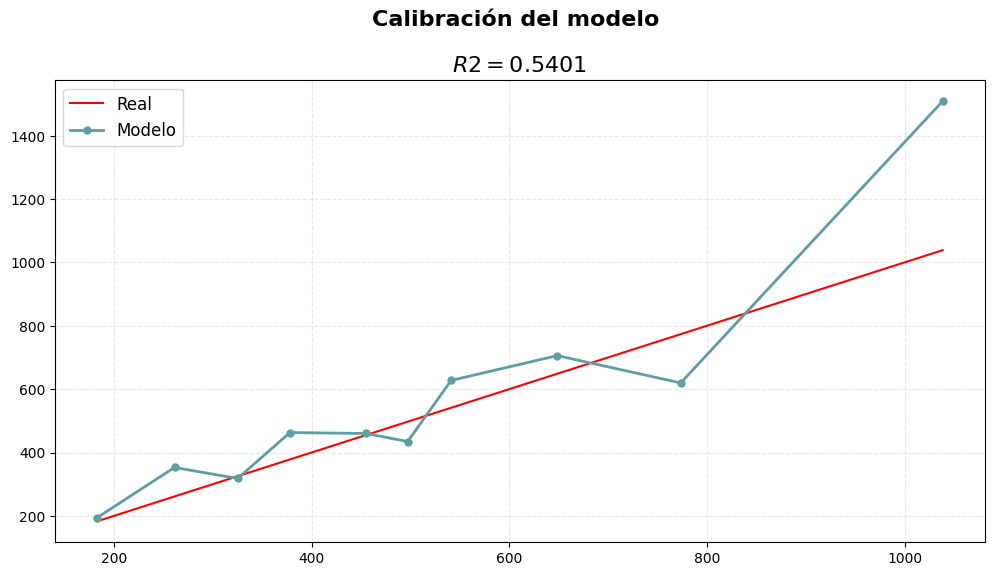

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100_000,
    learning_rate=0.01,
    reg_lambda=0.1,
    max_depth=6,
    random_state=42, 
    early_stopping_rounds=2000,
    eval_metric='rmse',
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
y_pred = model.predict(X_test)

calibracion(y_pred, y_test, bins=10)

## B) Todas las componentes

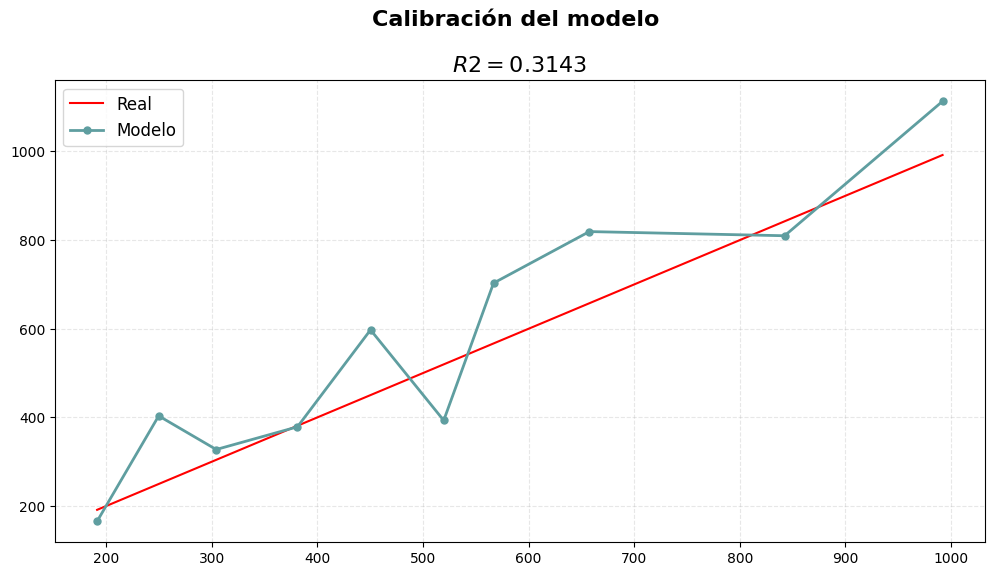

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_componentes.drop('cluster', axis=1), y,
                                                    test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100_000,
    learning_rate=0.01,
    reg_lambda=0.8,
    max_depth=6,
    random_state=42, 
    early_stopping_rounds=2000,
    eval_metric='rmse',
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
y_pred = model.predict(X_test)

calibracion(y_pred, y_test, bins=10)

## C) las tres primeras componentes

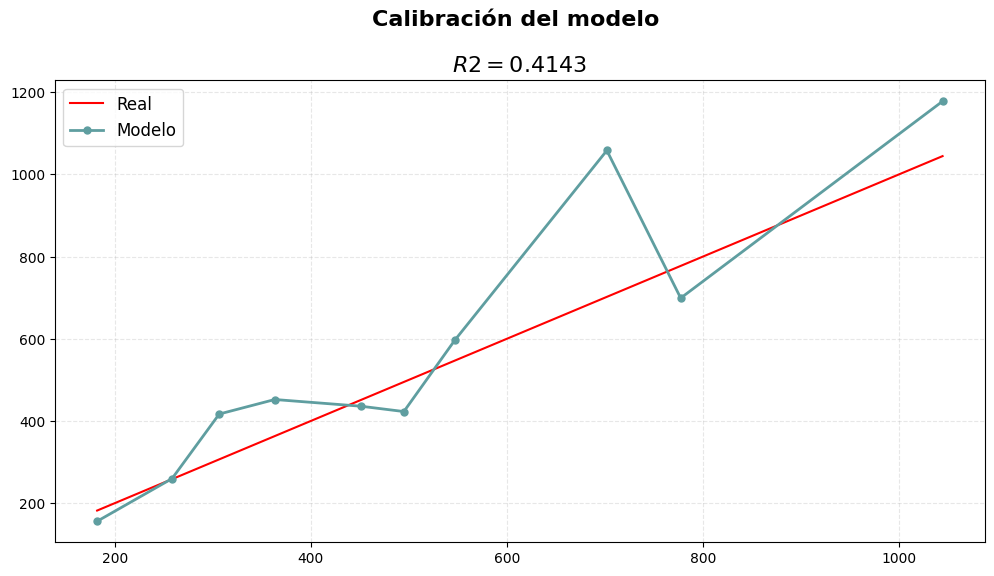

In [69]:
X_componentes_first3 = X_componentes[['PCA 1', 'PCA 2', 'PCA 3']]
X_train, X_test, y_train, y_test = train_test_split(X_componentes_first3, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100_000,
    learning_rate=0.01,
    reg_lambda=0.6,
    max_depth=6,
    random_state=42, 
    early_stopping_rounds=2000,
    eval_metric='rmse',
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
y_pred = model.predict(X_test)

calibracion(y_pred, y_test, bins=10)

# *¿Qué puedes concluir?*